<a href="https://colab.research.google.com/github/plaban1981/INEURON/blob/Supervised-Models/audio_processing_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Audio Processing for Machine Learning

Use the 'Clone' button if you want to run this notebook on a local/cloud machine, or use the 'Run' button to run it on BinderHub or Kaggle.

## Data dowload & exploration

We'll use a sample audio dataset from the Open Speech & Language Resouces (http://www.openslr.org/resources.php) for our analysis. We begin by downloading our data.

Next, let's download and unzip the data:

In [0]:
# Only on Linux, Mac and Windows WSL
!rm -rf openslr-sample.tgz openslr-sample
!wget https://www.dropbox.com/s/u5lkq2f64ljw7au/openslr-sample.tgz?dl=1 -O openslr-sample.tgz
!tar -zxf openslr-sample.tgz
!rm openslr-sample.tgz

--2019-06-16 10:11:23--  https://www.dropbox.com/s/u5lkq2f64ljw7au/openslr-sample.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/u5lkq2f64ljw7au/openslr-sample.tgz [following]
--2019-06-16 10:11:23--  https://www.dropbox.com/s/dl/u5lkq2f64ljw7au/openslr-sample.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc39bb4954b693fd7d64c4f1498.dl.dropboxusercontent.com/cd/0/get/Ai6PgSGZtJcxBK-E4eTWFhpmWi3LjzJp8dbGZGrbWT5qwh47tkwxrtfyz3EN_kj2iSC5H1GZao6aSzPWAOy6KehZVGhhUmb5qx-6fUiKmVsZAg/file?dl=1# [following]
--2019-06-16 10:11:24--  https://ucc39bb4954b693fd7d64c4f1498.dl.dropboxusercontent.com/cd/0/get/Ai6PgSGZtJcxBK-E4eTWFhpmWi3LjzJp8dbGZGrbWT5qwh47tkwxrtfyz3EN_kj2iSC5H1GZao6aSzPWAOy6KehZVGhhUmb5qx-6fUiKmVsZAg/file?dl=1
Resolving ucc39bb49

We can listen to audio files directly within Jupyter using a display widget.

In [0]:
import os
from IPython.display import Audio

DATA_DIR = 'openslr-sample'

In [0]:

audio_files = os.listdir(DATA_DIR)
len(audio_files), audio_files[:10]

(138,
 ['f0001_us_f0001_00026.wav',
  'f0001_us_f0001_00032.wav',
  'f0001_us_f0001_00033.wav',
  'f0001_us_f0001_00027.wav',
  'f0001_us_f0001_00019.wav',
  'f0001_us_f0001_00031.wav',
  'f0001_us_f0001_00025.wav',
  'f0001_us_f0001_00024.wav',
  'f0001_us_f0001_00030.wav',
  'f0001_us_f0001_00018.wav'])

In [0]:
example = DATA_DIR + "/" + audio_files[0]
Audio(example)

In [0]:
Audio(DATA_DIR + "/" + audio_files[1])

In [0]:
Audio(DATA_DIR + "/" + audio_files[23])

## Audio signals & sampling

We'll use the library `librosa` to process and play around with audio files.

In [0]:
import librosa

In [0]:
y, sr = librosa.load(example, sr=None)

In [0]:
print("Sample rate  :", sr)
print("Signal Length:", len(y))
print("Duration     :", len(y)/sr, "seconds")

Sample rate  : 16000
Signal Length: 60800
Duration     : 3.8 seconds


Audio is a continuous wave that is "sampled" by measuring the amplitude of the wave at a given time. How many times you sample per second is called the "sample rate" and can be thought of as the resolution of the audio. The higher the sample rate, the closer our discrete digital representation will be to the true continuous sound wave. Sample rates generally range from 8000-44100 but can go higher or lower.

Our signal is just a numpy array with the amplitude of the wave.

In [0]:
print("Type  :", type(y))
print("Signal: ", y)
print("Shape :", y.shape)

Type  : <class 'numpy.ndarray'>
Signal:  [0.         0.         0.         ... 0.00048828 0.00048828 0.00045776]
Shape : (60800,)


We can also display a play a numpy array using the `Audio` widget.

In [0]:
Audio(y, rate=sr)

Let's try some experiments now. Can you guess what the following will sound like?

In [0]:
Audio(y, rate=sr/2)

In [0]:
Audio(y, rate=sr*2)

In [0]:
y_new, sr_new = librosa.load(example, sr=sr*2)
Audio(y_new, rate=sr_new)

In [0]:
y_new, sr_new = librosa.load(example, sr=sr/2)
Audio(y_new, rate=sr_new)

## Waveforms, amplitude vs magnitude

A waveform is a curve showing the amplitude of the soundwave (y-axis) at time T (x-axis). Let's check out the waveform of our audio clip.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

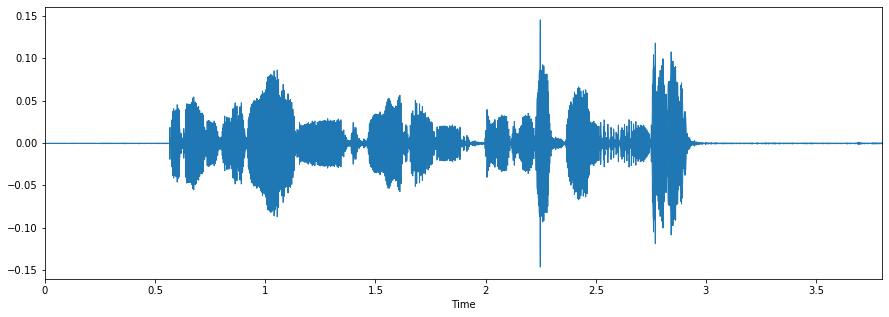

In [0]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y, sr=sr);

Amplitude and magnitude are often confused, but the difference is simple. Amplitude of a wave is just the distance, positive or negative, from the equilibrium (zero in our case), and magnitude is the absolute value of the amplitude. In audio we sample the amplitude.

## Frequency and Pitch

Most of us remember frequency from physics as cycles per second of a wave. It's the same for sound, but really hard to see in the above image. How many cycles are there? How can there be cycles if it's not regular? The reality is that sound is extremely complex, and the above recording of human speech is the combination of many different frequencies added together. To talk about frequency and pitch, it's easier to start with a pure tone, so let's make one.

Human hearing ranges from 20hz to 20,000hz, hz=hertz=cycles per second. The higher the frequency, the more cycles per second, and the "higher" the pitch sounds to us. To demonstrate, let's make a sound at 500hz, and another at 5000hz.

In [0]:
import numpy as np

In [0]:
# Adapted from https://musicinformationretrieval.com/audio_representation.html
# An amazing open-source resource, especially if music is your sub-domain.
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)
clip_500hz = make_tone(500)
clip_5000hz = make_tone(5000)

In [0]:
Audio(clip_500hz, rate=sr)

In [0]:
Audio(clip_5000hz, rate=sr)

500 cycles per second, 16000 samples per second, means 1 cycle = 16000/500 = 32 samples, let's see 2 cycles.

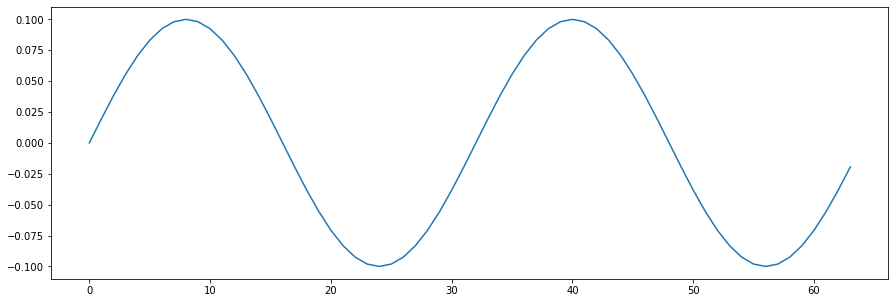

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(clip_500hz[0:64]);

Now let's look at 5000Hz.

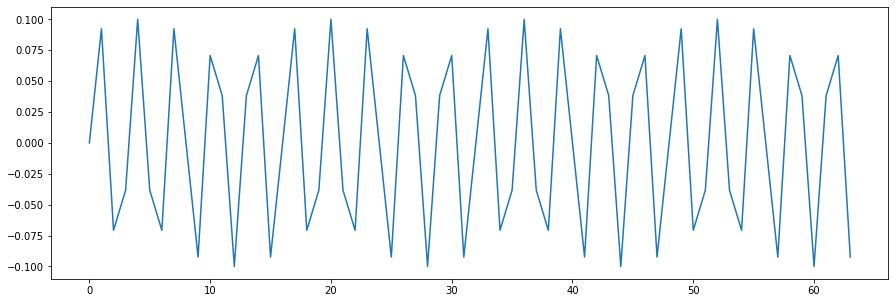

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(clip_5000hz[0:64]);

Now let's put the two sounds together.

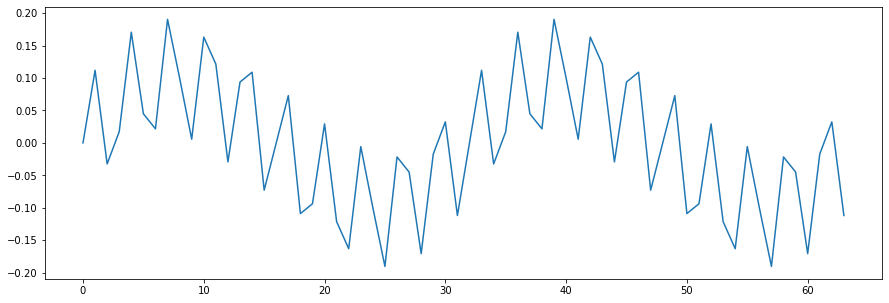

In [0]:
plt.figure(figsize=(15, 5))
plt.plot((clip_500hz + clip_5000hz)[0:64]);

In [0]:
Audio(clip_500hz + clip_5000hz, rate=sr)

Pitch is a musical term that means the human perception of frequency. This concept of human perception instead of actual values seems vague and non-scientific, but it is hugely important for machine learning because most of what we're interested in, speech, sound classification, music...etc are inseparable from human hearing and how it functions.

Let's do an experiment and increase the frequency of the above tones by 500hz each and see how much this moves our perception of them

In [0]:
clip_500_to_1000 = np.concatenate([make_tone(500), make_tone(1000)])
clip_5000_to_5500 = np.concatenate([make_tone(5000), make_tone(5500)])

In [0]:
# first half of the clip is 500hz, 2nd is 1000hz
Audio(clip_500_to_1000, rate=sr)

In [0]:
# first half of the clip is 5000hz, 2nd is 5500hz
Audio(clip_5000_to_5500, rate=sr)

Notice that the pitch of the first clip seems to change more even though they were shifted by the same amount. This makes intuitive sense as the frequency of the first was doubled and the frequency of the second only increased 10%. Like other forms of human perception, hearing is not linear, it is logarithmic. This will be important later as the range of frequencies from 100-200hz convey as much information to us as the range from 10,000-20,000hz.

## Mel scale

The mel scale is a human-centered metric of audio perception that was developed by asking participants to judge how far apart different tones were.

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/349ff3f61581b99c709f4ed29ab5e1eb6d52c98a)

| Frequency | Mel Equivalent |
| --- | --- |
| 20 | 0 |
| 160 | 250 |
| 394 | 500 |
| 670 | 750 |
| 1000 | 1000 |
| 1420 | 1250 |
| 1900 | 1500 |
| 2450 | 1750 |
| 3120 | 2000 |
| 4000 | 2250 |
| 5100 | 2500 |
| 6600 | 2750 |
| 9000 | 3000 |
| 14000 | 3250 |

## Decibels

Just like frequency, human perception of loudness occurs on a logarithmic scale. A constant increase in the amplitude of a wave will be perceived differently if the original sound is soft or loud.

Decibels measure the ratio of power between 2 sounds, and each 10x increase in the energy of the wave (multiplicative) results in a 10dB increase in sound (additive). Thus something that is 20dB louder has 100x (10*10) the amount of energy, something that is 25dB louder has (10^2.5) = 316.23x more energy. 

![image.png](https://boomspeaker.com/wp-content/uploads/2018/04/DB-LEVEL-CHART-LOUD.jpg)

## Spectrogram - visual representation of audio

We'll plot the time on the x-axis, frequencies on the y-axis, and use the color to represent the amplitude of various frequencies.

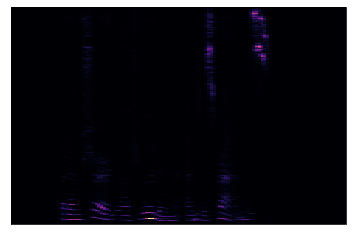

In [0]:
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
librosa.display.specshow(sg_mag);

Next we use the mel-scale instead of raw frequency. 

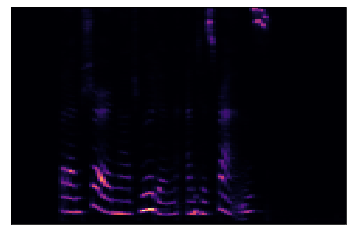

In [0]:
sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=sr)
librosa.display.specshow(sg1);

Next, let's use the decibel scale, and labels the x & y axes.

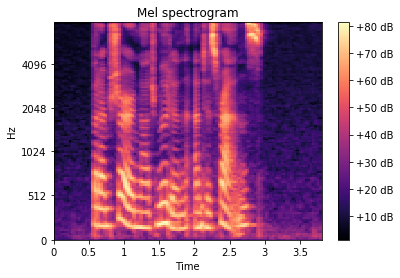

In [0]:
sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
librosa.display.specshow(sg2, sr=16000, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram');

Every point in the square represents the energy at the frequency of it's y-coordinate at the time of it's x-coordinate. 

In [0]:
sg2.min(), sg2.max(), sg2.mean()

(1.3055977504610752, 81.30559775046108, 29.65997874062258)

The spectrogram itself is nothing special, simply a 2d numpy array

In [0]:
type(sg2), sg2.shape

(numpy.ndarray, (128, 119))

In fact, we can we it as an image.

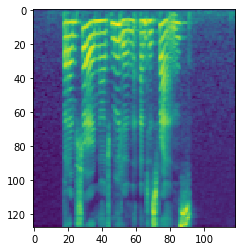

In [0]:
plt.imshow(sg2);

It looks inverted because the y-axis is inverted. Also, the ticks on the y-axis now represent mel frequencies, and the ticks on the x-asis represent the actual sample length. 

While there's a lot more to explore about audio processing, we are going to stop here, since we have successfully converted the audio into images, and now we can use same models that we use for computer vision with audio.

Learn more about audio processing:

- https://www.kaggle.com/deepaksinghrawat/in-depth-introduction-to-audio-for-beginners
- https://github.com/sevenfx/fastai_audio

In [0]:
# Clean up (for Kaggle)
# !rm -rf {DATA_DIR}

## Save and Commit

In [0]:
import jovian

<IPython.core.display.Javascript object>

In [0]:
jovian.commit()

[jovian] Saving notebook..


<IPython.core.display.Javascript object>